# Table of Contents

### 1. [Imports](#Imports)
### 2. [Setting Up Constants and Variables](#Constants)
### 3. [Re-Usable Functions](#ReUsable-Functions)
### 4. [Raw Data Process](#Raw-Data-Process)
### 5. [Create Reference Table](#Create-Reference-Table)
### 6. [Checking The Reference Table](#Checking-The-Reference-Table)

# Imports

In [20]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# Try to import parquet engines
try:
    import pyarrow
    PARQUET_ENGINE = 'pyarrow'
except ImportError:
    try:
        import fastparquet
        PARQUET_ENGINE = 'fastparquet'
    except ImportError:
        print("Warning: No parquet engine found. Installing pyarrow recommended.")
        print("Run: pip install pyarrow")
        PARQUET_ENGINE = None

# Constants

In [3]:
PARAMS = [
    'AvgSurfT_inst',
    'CanopInt_inst',
    'LWdown_f_tavg',
    'Psurf_f_inst',
    'Qair_f_inst',
    'SnowDepth_inst',
    'SWdown_f_tavg',
    'Tair_f_inst',
    'TVeg_tavg',
    'Wind_f_inst',
    'Rainf_tavg'
]  

AGGREGATION = {
    'Rainf_tavg': 'sum',        # Rain accumulates over time
    'SnowDepth_inst': 'sum',    # Snow accumulation over time  
    'CanopInt_inst': 'sum',     # Water accumulation over time
    'Tair_f_inst': 'mean',      # Daily average temperature
    'AvgSurfT_inst': 'mean',    # Daily average surface temperature
    'Psurf_f_inst': 'mean',     # Daily average pressure
    'Qair_f_inst': 'mean',      # Daily average humidity
    'Wind_f_inst': 'mean',      # Daily average wind speed
    'LWdown_f_tavg': 'mean',    # Daily average longwave radiation
    'SWdown_f_tavg': 'mean',    # Daily average shortwave radiation
    'TVeg_tavg': 'mean'         # Daily average transpiration
}

DATES = [
    '2024_March',
    '2024_April',
    '2024_May',
    '2024_June',
    '2024_July',
    '2024_Aug',
    '2024_Sept',
    '2024_Oct',
    '2024_Nov',
    '2024_Dec',
    '2025_Jan',
    '2025_Feb',
]

# ReUsable Functions

Read in monthly CSVs, aggregate upto daily granularity and restructure the data to be column-wise lagged

In [6]:
def read_raw_csv(filename: str) -> pd.DataFrame:
    """Read a CSV file and return a pandas DataFrame."""
    file_path = Path('data/raw') / filename
    return pd.read_csv(file_path)

# Raw Data Process

In [13]:
for parameter in PARAMS:

    print("-" * 50)
    print(f'Parameter: {parameter}')
    print("-" * 50)

    monthly_daily_dfs = []
    
    for date in DATES:

        print(f'date: {date}')
        file = parameter + '_data_' + date + '.csv'
        print("file: " + file)
        
        try:
            df = read_raw_csv(file)
            print(f"Successfully loaded {file}")
            print(f"Shape: {df.shape}")
            print(f"Columns: {list(df.columns)}")
        except Exception as e:
            print(f"Error: {e}")
        
        # Check missing values in final column
        final_col = df.columns[-1]
        missing_count = df[final_col].isna().sum()
        print(f"Missing values in '{final_col}': {missing_count}")

        # Print ranges of longitude and latitude
        lon_range = (df['longitude'].min(), df['longitude'].max())
        lat_range = (df['latitude'].min(), df['latitude'].max())
        print(f"Longitude range: {lon_range}")
        print(f"Latitude range: {lat_range}")

        # Aggregate 3-hourly data to daily
        daily_df = df.groupby(['longitude', 'latitude', 'year', 'month', 'day']).agg({
            final_col: AGGREGATION.get(parameter, 'mean')
        }).reset_index()
    
        print(f"Original shape: {df.shape}")
        print(f"Daily aggregated shape: {daily_df.shape}")

        monthly_daily_dfs.append(daily_df)
        
        print("-" * 50)
    
    if monthly_daily_dfs:

        consolidated_df = pd.concat(monthly_daily_dfs, ignore_index=True)
        print(f"Shape: {consolidated_df.shape}")
        print(f"Columns: {list(consolidated_df.columns)}")

        df_sorted = consolidated_df.sort_values(['longitude', 'latitude', 'year', 'month', 'day']).reset_index(drop=True)

        for lag in range(1, 14):
            df_sorted[f'{parameter}_lag{lag}'] = df_sorted.groupby(['longitude', 'latitude'])[parameter].shift(lag)

        output_path = os.path.join('data', 'interim', f"{parameter}.parquet")
        df_sorted.to_parquet(output_path, index=False, engine=PARQUET_ENGINE)

--------------------------------------------------
Parameter: AvgSurfT_inst
--------------------------------------------------
date: 2024_March
file: AvgSurfT_inst_data_2024_March.csv
Successfully loaded AvgSurfT_inst_data_2024_March.csv
Shape: (3759432, 7)
Columns: ['year', 'month', 'day', 'hour', 'longitude', 'latitude', 'AvgSurfT_inst']
Missing values in 'AvgSurfT_inst': 0
Longitude range: (np.float64(-179.5), np.float64(179.5))
Latitude range: (np.float64(-54.5), np.float64(83.5))
Original shape: (3759432, 7)
Daily aggregated shape: (469929, 6)
--------------------------------------------------
date: 2024_April
file: AvgSurfT_inst_data_2024_April.csv
Successfully loaded AvgSurfT_inst_data_2024_April.csv
Shape: (3638160, 7)
Columns: ['year', 'month', 'day', 'hour', 'longitude', 'latitude', 'AvgSurfT_inst']
Missing values in 'AvgSurfT_inst': 0
Longitude range: (np.float64(-179.5), np.float64(179.5))
Latitude range: (np.float64(-54.5), np.float64(83.5))
Original shape: (3638160, 7)
Da

# Create Reference Table

Creating a reference/base table from the iterim tables

In [15]:
# file_path = os.path.join('data', 'processed', filename)
# pd.read_parquet(file_path, engine=PARQUET_ENGINE)

os.makedirs('data/processed', exist_ok=True)
    
# Initialize holding DataFrame
holding_df = pd.DataFrame()
    
# Loop through each parameter
for i, param in enumerate(PARAMS):
    filename = f"{param}.parquet"
    print(f"\n Processing: {filename}")
        
    try:
        file_path = os.path.join('data', 'interim', filename)
        df = pd.read_parquet(file_path, engine=PARQUET_ENGINE)
        print(f"Loaded: {df.shape}")
            
        # Extract unique instances (longitude, latitude, year, month, day)
        instances = df[['longitude', 'latitude', 'year', 'month', 'day']].copy()
        print(f"Extracted instances: {instances.shape}")
            
        # Check if instances are unique within this CSV
        unique_count = instances.drop_duplicates().shape[0]
        total_count = instances.shape[0]
        if unique_count != total_count:
            print(f"Warning: {total_count - unique_count} duplicate instances found in {filename}")
            
        # Concatenate to holding DataFrame
        if holding_df.empty:
            holding_df = instances.copy()
            print(f"First CSV: {holding_df.shape}")
        else:
            holding_df = pd.concat([holding_df, instances], ignore_index=True)
            print(f"Concatenated: {holding_df.shape}")
                
            # Deduplicate after each CSV to keep memory usage low
            print(f"Deduplicating the holding table...")
            holding_df = holding_df.drop_duplicates(subset=['longitude', 'latitude', 'year', 'month', 'day'])
            print(f"After deduplication: {holding_df.shape}")
                
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue
    
    # Final sort for consistency
    print(f"\nFinal sorting and cleanup...")
    reference_table = holding_df.sort_values(['longitude', 'latitude', 'year', 'month', 'day']).reset_index(drop=True)
    

    # Verify no duplicates remain
    duplicate_check = reference_table.duplicated(subset=['longitude', 'latitude', 'year', 'month', 'day']).sum()
    if duplicate_check == 0:
        print("No duplicate instances remain in reference table")
    else:
        print(f"{duplicate_check} duplicate instances still found")
    
    # Save reference table
    output_path = 'data/processed/reference_table.csv'
    reference_table.to_csv(output_path, index=False)
    print(f"Reference table saved to: {output_path}")


 Processing: AvgSurfT_inst.parquet
Loaded: (5533035, 19)
Extracted instances: (5533035, 5)
First CSV: (5533035, 5)

Final sorting and cleanup...
No duplicate instances remain in reference table
Reference table saved to: data/processed/reference_table.csv

 Processing: CanopInt_inst.parquet
Loaded: (5533035, 19)
Extracted instances: (5533035, 5)
Concatenated: (11066070, 5)
Deduplicating the holding table...
After deduplication: (5533035, 5)

Final sorting and cleanup...
No duplicate instances remain in reference table
Reference table saved to: data/processed/reference_table.csv

 Processing: LWdown_f_tavg.parquet
Loaded: (5593625, 19)
Extracted instances: (5593625, 5)
Concatenated: (11126660, 5)
Deduplicating the holding table...
After deduplication: (5593625, 5)

Final sorting and cleanup...
No duplicate instances remain in reference table
Reference table saved to: data/processed/reference_table.csv

 Processing: Psurf_f_inst.parquet
Loaded: (5593625, 19)
Extracted instances: (5593625

# Checking The Reference Table

Spend some time exploring and checking the reference table. Understanding the structure of the data and if anything is missing

Reference table shape: (5593625, 5)
Rows: 5593625, Columns: 5
File size: 110.33 MB

Column names: ['longitude', 'latitude', 'year', 'month', 'day']

Date range:
Min date: 2024-03-01
Max date: 2025-02-28

Instances per month:
  2024-Mar: 475,075 instances
  2024-Apr: 459,750 instances
  2024-May: 475,075 instances
  2024-Jun: 459,750 instances
  2024-Jul: 475,075 instances
  2024-Aug: 475,075 instances
  2024-Sep: 459,750 instances
  2024-Oct: 475,075 instances
  2024-Nov: 459,750 instances
  2024-Dec: 475,075 instances
  2025-Jan: 475,075 instances
  2025-Feb: 429,100 instances

Date continuity check:
Complete date coverage: 365 consecutive days

Geographic coordinate ranges:
Latitude: -90° to +90° (South Pole to North Pole)
Longitude: -180° to +180° (West to East from Prime Meridian)

Coordinate validity check:
Latitude valid: True
Longitude valid: True

Actual coordinate ranges in data:
Latitude: -54.50° to 83.50°
Longitude: -179.50° to 179.50°

Unique location pairs:
Unique longitud

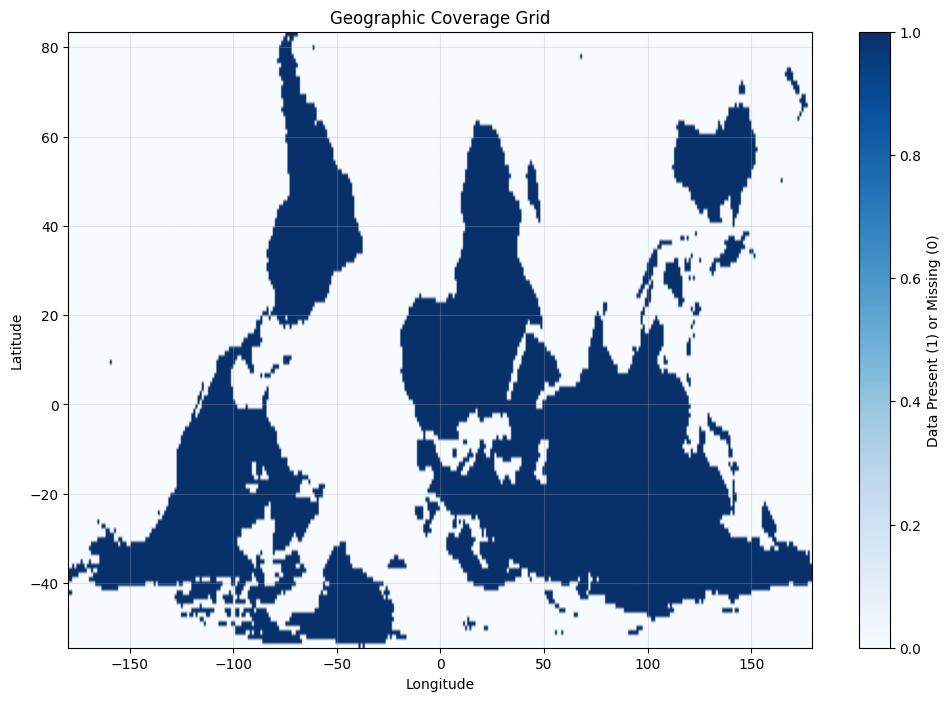

Coverage grid saved to: data/processed/coverage_grid.png

Coverage explanation:
Theoretical maximum (199,163) includes ALL possible longitude-latitude combinations globally.
Actual coverage (15,325) represents only LAND-BASED locations.
This is expected since the NASA dataset excludes ocean/sea locations.

Geographic considerations:
Geographic bias: Data covers latitude -54.5° to 83.5° (Southern Hemisphere to Arctic)
  - Northern Hemisphere heavy coverage
  - Ensure training data represents diverse geographic regions
Scale normalization: Current ranges - Longitude: -179.5° to 179.5°, Latitude: -54.5° to 83.5°
  - Consider scaling to [0,1] or [-1,1] for better network performance
  - This will help the network learn spatial patterns more effectively

Date instances per location:
Total unique locations: 15325
Locations with most date instances:
 longitude  latitude  date_count
    -179.5      66.5         365
      67.5      29.5         365
      66.5      63.5         365
      66.5   

In [ ]:
file_path = os.path.join('data', 'processed', 'reference_table.csv')
ref_table = pd.read_csv(file_path)
    
# Get file size
file_path = Path('data/processed/reference_table.csv')
file_size_mb = file_path.stat().st_size / (1024 * 1024)
    
# Print shape
print(f"Reference table shape: {ref_table.shape}")
print(f"Rows: {ref_table.shape[0]}, Columns: {ref_table.shape[1]}")
    
# Print file size
print(f"File size: {file_size_mb:.2f} MB")
    
# Print column names
print(f"\nColumn names: {list(ref_table.columns)}")
    
# Create date field
ref_table['date'] = pd.to_datetime(ref_table[['year', 'month', 'day']])
    
# Print date range
print(f"\nDate range:")
print(f"Min date: {ref_table['date'].min().strftime('%Y-%m-%d')}")
print(f"Max date: {ref_table['date'].max().strftime('%Y-%m-%d')}")
    
# Count instances per month
print(f"\nInstances per month:")
monthly_counts = ref_table.groupby(['year', 'month']).size().reset_index(name='count')
    
# Format month names for better readability
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
    
for _, row in monthly_counts.iterrows():
    month_name = month_names[row['month']]
    print(f"  {row['year']}-{month_name}: {row['count']:,} instances")
    
# Check date continuity
print(f"\nDate continuity check:")
date_range = pd.date_range(start=ref_table['date'].min(), end=ref_table['date'].max(), freq='D')
missing_dates = date_range.difference(ref_table['date'])
    
if len(missing_dates) == 0:
    print(f"Complete date coverage: {len(date_range)} consecutive days")
else:
    print(f"Missing dates: {len(missing_dates)} gaps found")
    print(f"First few missing: {missing_dates[:5]}")
    
# Print coordinate ranges
print(f"\nGeographic coordinate ranges:")
print(f"Latitude: -90° to +90° (South Pole to North Pole)")
print(f"Longitude: -180° to +180° (West to East from Prime Meridian)")

# Check coordinate validity
valid_lat = (-90 <= ref_table['latitude'].min()) and (ref_table['latitude'].max() <= 90)
valid_lon = (-180 <= ref_table['longitude'].min()) and (ref_table['longitude'].max() <= 180)
    
print(f"\nCoordinate validity check:")
print(f"Latitude valid: {valid_lat}")
print(f"Longitude valid: {valid_lon}")
    
# Print actual min/max values
print(f"\nActual coordinate ranges in data:")
print(f"Latitude: {ref_table['latitude'].min():.2f}° to {ref_table['latitude'].max():.2f}°")
print(f"Longitude: {ref_table['longitude'].min():.2f}° to {ref_table['longitude'].max():.2f}°")
    
# Count unique longitude-latitude pairs
print(f"\nUnique location pairs:")
unique_locations = ref_table[['longitude', 'latitude']].drop_duplicates()
print(f"Unique longitude-latitude pairs: {len(unique_locations)}")
    
# Calculate expected counts based on 0.5° resolution
lon_range = ref_table['longitude'].max() - ref_table['longitude'].min()
lat_range = ref_table['latitude'].max() - ref_table['latitude'].min()

expected_lon_count = int(lon_range / 0.5) + 1
expected_lat_count = int(lat_range / 0.5) + 1
theoretical_max_resolution = expected_lon_count * expected_lat_count

print(f"Maximum possible pairs (0.5° resolution): {expected_lon_count} longitudes × {expected_lat_count} latitudes = {theoretical_max_resolution}")

# Create location grid visualization
print(f"\nCreating location grid visualization...")
    
try:
    # Get unique coordinates
    unique_lons = sorted(ref_table['longitude'].unique())
    unique_lats = sorted(ref_table['latitude'].unique())
        
     # Create a grid (0 = no data, 1 = has data)
    grid = np.zeros((len(unique_lats), len(unique_lons)))
        
    # Mark locations that have data
    for _, row in ref_table[['longitude', 'latitude']].drop_duplicates().iterrows():
        lon_idx = unique_lons.index(row['longitude'])
        lat_idx = unique_lats.index(row['latitude'])
        grid[lat_idx, lon_idx] = 1
        
    # Plot the grid
    plt.figure(figsize=(12, 8))
    plt.imshow(grid, cmap='Blues', aspect='auto', 
                extent=[min(unique_lons), max(unique_lons), min(unique_lats), max(unique_lats)])
    plt.colorbar(label='Data Present (1) or Missing (0)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographic Coverage Grid')
    plt.grid(True, alpha=0.3)
        
    # Save the plot
    # plt.savefig('data/processed/coverage_grid.png', dpi=300, bbox_inches='tight')
    plt.show()
        
    print(f"Coverage grid saved to: data/processed/coverage_grid.png")

    # Explain the coverage difference
    print(f"\nCoverage explanation:")
    print(f"Theoretical maximum ({theoretical_max_resolution:,}) includes ALL possible longitude-latitude combinations globally.")
    print(f"Actual coverage ({len(unique_locations):,}) represents only LAND-BASED locations.")
    print(f"This is expected since the NASA dataset excludes ocean/sea locations.")

    # Add these print statements after your coverage explanation:
    print(f"\nGeographic considerations:")
    print(f"Geographic bias: Data covers latitude -54.5° to 83.5° (Southern Hemisphere to Arctic)")
    print(f"  - Northern Hemisphere heavy coverage")
    print(f"  - Ensure training data represents diverse geographic regions")
    print(" ")
    print(f"Scale normalization: Current ranges - Longitude: -179.5° to 179.5°, Latitude: -54.5° to 83.5°")
    print(f"  - Consider scaling to [0,1] or [-1,1] for better network performance")
    print(f"  - This will help the network learn spatial patterns more effectively")
        
except Exception as e:
    print(f"Error creating visualization: {e}")
    print("Skipping grid visualization...")
    

# Count instances per location
print(f"\nDate instances per location:")
location_counts = ref_table.groupby(['longitude', 'latitude']).size().reset_index(name='date_count')
    
# Sort by count (descending) to see most frequent locations
location_counts_sorted = location_counts.sort_values('date_count', ascending=False)
    
print(f"Total unique locations: {len(location_counts)}")
print(f"Locations with most date instances:")
print(location_counts_sorted.head(10).to_string(index=False))
    
# Summary statistics
print(f"\nLocation coverage statistics:")
print(f"Average dates per location: {location_counts['date_count'].mean():.1f}")
print(f"Median dates per location: {location_counts['date_count'].median():.1f}")
print(f"Min dates per location: {location_counts['date_count'].min()}")
print(f"Max dates per location: {location_counts['date_count'].max()}")
    
# Check for locations with only one date instance
single_date_locations = location_counts[location_counts['date_count'] == 1]
print(f"Locations with only 1 date instance: {len(single_date_locations)}")
    
# Check for locations with many date instances (e.g., >100)
frequent_locations = location_counts[location_counts['date_count'] > 100]
print(f"Locations with >100 date instances: {len(frequent_locations)}")

# Joining 